# Comparison of clustering methods

We compare in this final hands-on various clustering methods, on toy data sets (inspired by https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html). See https://scikit-learn.org/stable/modules/clustering.html# for an introduction to clustering methods, and in particular https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation for elements on how to evaluate the performance of clustering methods. We focus here on the silhouette coefficient since this is the first metric in the list which can be used when labels are not known. Other metrics could of course be considered.

We focus on $K$-means, agglomerative clustering, density-based methods (DBSCAN) and Gaussian mixture. Spectral methods can also be tested.

**There are 6 questions to answer.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import time
from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

**Question 1.** What is the silhouette score? Which values of this metric are the best? The worst?

See additional explanations in Section 21.3.7.3 of [Murphy] or on the wikipedia webpage https://en.wikipedia.org/wiki/Silhouette_(clustering)
In sklearn plots such as the ones shown on https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html each line corresponds to the value of the silhouette coefficient for a data point in the cluster, namely
$$
s_i = \frac{b_i-a_i}{\max(a_i,b_i)},
$$
where $a_i$ is the average distance between the given data point $x_i$ and all other data points in the same cluster, while $b_i$ is the average distance between a sample and all other points in the next nearest cluster. The coefficient $s_i$ is between $-1$ and 1, close to 1 for correct clustering and close to -1 for incorrect clustering. 
The final silhouette coefficient is the average of the silhouette coefficients for each data point.

## Dataset generation

We first generate datasets. Their sizes are large enough to see the scalability of the algorithms, but not too large to avoid too long running times. See https://scikit-learn.org/stable/datasets/sample_generators.html#sample-generators for a more precise description of the methods to generate datasets, and the underlying rationale behind them.

In [2]:
# desired number of samples
n_samples = 1500

# reinitialization of the random number generator
np.random.seed(0)

#--- generation of four target datasets ----
# see https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,noise=.05)
# see https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
# see https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
# unstructured dataset = uniform distribution, no label for coloring
no_structure = np.random.rand(n_samples, 2), None

chosen_datasets = [noisy_circles, noisy_moons, blobs, no_structure]
chosen_datasets_names = ['noisy_circles', 'noisy_moons', 'blobs', 'no_structure']

We next plot the datasets. They could also be normalized to study the impact of renormalization procedures on the quality of the clustering.

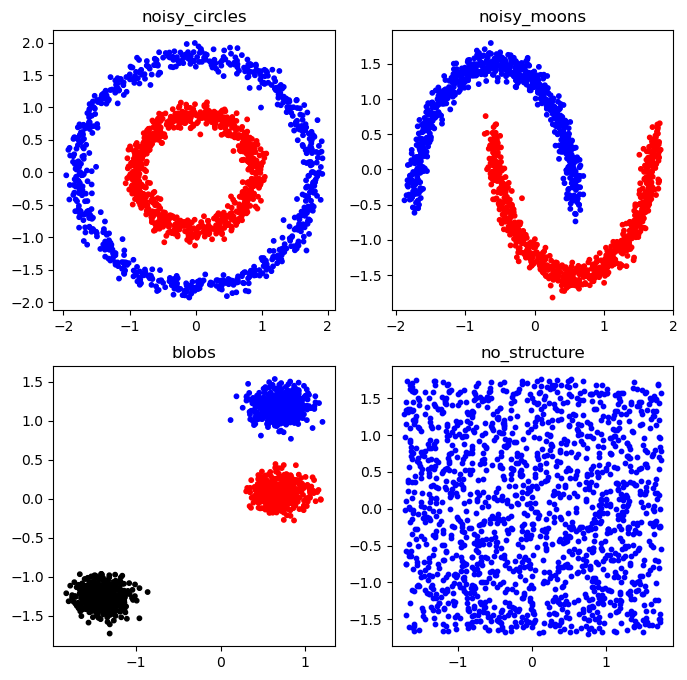

In [3]:
plt.figure(figsize=(8,8))
# baseline colors
colors = np.array([x for x in 'brkgmcy'])
# repeating the color vector for situations when there are many clusters
colors = np.hstack([colors] * 20)

for i in range(4):
    plt.subplot(2, 2, i+1)
    Y = chosen_datasets[i][1]
    X = chosen_datasets[i][0]
    # if normalization is wanted: add the following two lines 
    X = StandardScaler().fit_transform(X)
    chosen_datasets[i] = X,Y
    if Y is None:
        plt.scatter(X[:,0],X[:,1],s=10,color=colors[0])
    else:
        plt.scatter(X[:,0],X[:,1],s=10,color=colors[Y])
    plt.title(chosen_datasets_names[i])
plt.show()

We first invidually test all clustering methods on the various datasets, in order to fine tune their parameters.

# $K$-means

The important parameters to choose for $K$-means are the number of classes, and the way distances are measured. See https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [4]:
from sklearn.cluster import KMeans

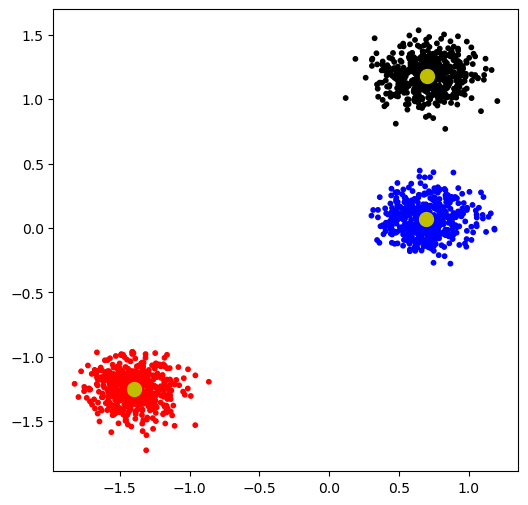

Silhouette score: 0.8104321767519068


In [5]:
# choice of dataset
index = 2
# choice of parameters for K-means
kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)

# performing the clustering
X,Y = chosen_datasets[index]
Y_pred = kmeans.fit_predict(X)

# plotting the classes and the cluster centers
plt.figure(figsize=(6,6))
plt.scatter(X[:,0],X[:,1],s=10,color=colors[Y_pred])
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],marker='o',s=100,color='y')
plt.show()

# evaluation of the performance
print("Silhouette score:",silhouette_score(X,Y_pred))

**Question 2.** Test the influence of the various parameters and the nature of the dataset on the results. Start with the 'blobs' data set and $K=3$ clusters, then change the number of clusters; next change the dataset.

For 'blobs', clustering is convincing with $K=2$ or better $K=3$ clusters, with silhouette coefficients of about 0.8; this decreases to 0.67 with $K=4$. When changing the parameter 'random_state', different clusters are cut in two for $K=4$. For $K=5$ two clusters are cut in two, with a silhouette coefficient of 0.54; for $K=6$ all clusters are cut in two, with silhouette score of 0.35.

As one can anticipate, clustering is not convincing for all the data sets, including the ones having some structure. The unstructured data set is however cut in a rather balanced manner.

## Agglomerative clustering

One drawback of $K$-means is that the number of clusters has to be fixed in advance. This can be avoided by progressively merging data clusters, and inspecting the associated graph of overall loss. See https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html

In [6]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

This is the function to plot the dendogram, see https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html. It creates the linkage matrix first, then calls the dedicated scipy function https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram
The various elements are based on the attributes of the agglomerative clustering method.

In [7]:
def plot_dendrogram(model, **kwargs):
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    # create the linkage matrix with the appropriate format
    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    # plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

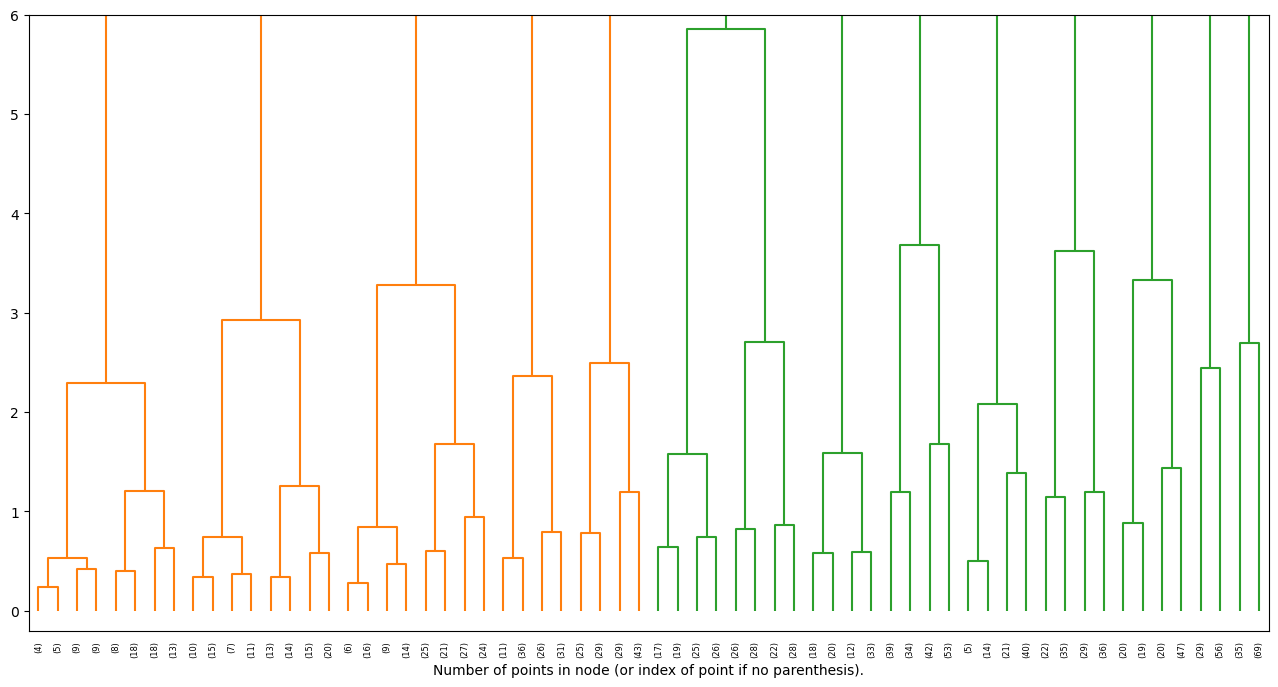

In [8]:
# choice of dataset
index = 1
# setting distance_threshold=0 ensures that the full tree is computed
agglo_cluster = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

# performing the clustering
X,Y = chosen_datasets[index]
agglo_cluster.fit(X)

plt.figure(figsize=(16,8))
plot_dendrogram(agglo_cluster, truncate_mode="level", p=5) # change depth of representation with p
plt.ylim(-0.2,6) # to better see the beginning
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

We can next decide on a number of clusters and perform the clustering.

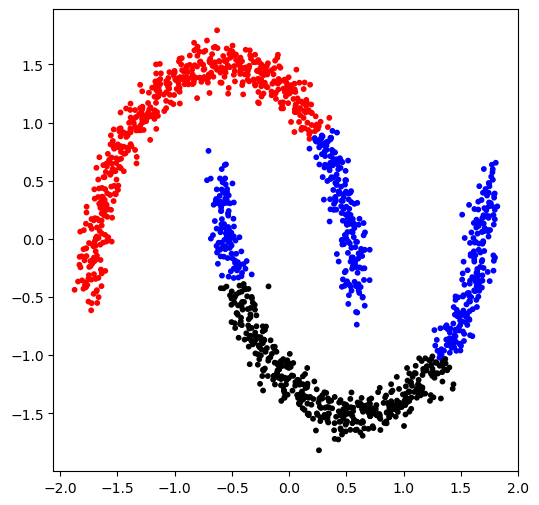

Silhouette score: 0.38988144230653476


In [9]:
# clustering with a fixed number of clusters
agglo_cluster = AgglomerativeClustering(n_clusters=3)
X,Y = chosen_datasets[index]
agglo_cluster.fit(X)
Y_pred = agglo_cluster.labels_

# plot the dataset and the clusters
plt.figure(figsize=(6,6))
plt.scatter(X[:,0],X[:,1],s=10,color=colors[Y_pred])
plt.show()

# evaluation of the performance
print("Silhouette score:",silhouette_score(X,Y_pred))

**Question 3.** Which distance between clusters is used by default? Test the influence of the various parameters and the nature of the dataset on the results.

The default choice of linkage method is Ward.

For $K=3$, the results are similar to K-means. For $K=6$ (a cut suggested by the dendrogram), one splits all clusters in two, but less symmetrically than with K-means. Similar results are also obtained for the other datasets, with no clear/clean way of cutting the dendrogram.

## Density-based methods (DBSCAN)

We next consider a density-based method which automatically sets the number of clusters depending on input parameters. See https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html and https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py

In [10]:
from sklearn.cluster import DBSCAN

Estimated number of clusters: 3
Estimated number of noise points: 11


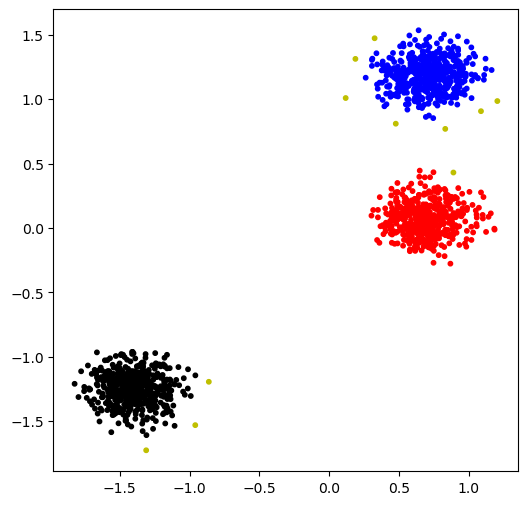

Silhouette score: 0.8012256767542554


In [11]:
# choice of dataset
index = 2
dbscan_cluster = DBSCAN(eps=0.1, min_samples=5)

# performing the clustering
X,Y = chosen_datasets[index]
dbscan_cluster.fit(X)
Y_pred = dbscan_cluster.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(Y_pred)) - (1 if -1 in Y_pred else 0)
n_noise_ = list(Y_pred).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# plot the figure
plt.figure(figsize=(6,6))
plt.scatter(X[:,0],X[:,1],s=10,color=colors[Y_pred])
plt.show()

# evaluation of the performance
print("Silhouette score:",silhouette_score(X,Y_pred))

**Question 4.** Test the influence of the various parameters for the datasets at hand.

For 'blobs': for $\varepsilon = 1$, two clusters are merged; for 0.01, almost all points are considered as noise. The value 0.1 seems a good compromise, allowing to identify 3 clusters and a small number of outliers.

The value 0.1 gives very bad results for 'noisy_circles' since it separates the data into too many clusters. The value 0.2 gives much better results as the data is correctly separated into two clusters -- but the silhouette coefficient is low in any case because of the shape of the data. 

For 'noisy_moon', the choice of $\varepsilon$ is less critical -- values between 0.1 and 0.4 allow to find two clusters. For smaller values, most points are outliers; while for larger values there is only a single cluster.

For 'uniform', there is a single cluster for 0.2, many clusters for 0.1 (with a large number of outliers), and mostly outliers for 0.05 and below.

## Gaussian mixture models

We consider here the use of Gaussian mixture models, which can be seen as some soft K-means. See https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture and https://scikit-learn.org/stable/modules/mixture.html#gmm

In [12]:
from sklearn.mixture import GaussianMixture

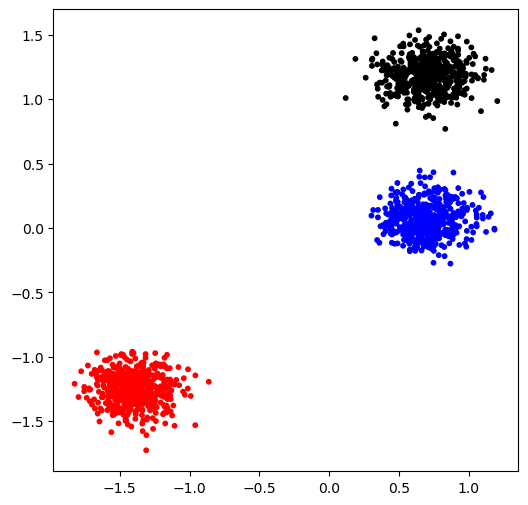

Silhouette score: 0.8104321767519068


In [13]:
# choice of dataset
index = 2
gm_cluster = GaussianMixture(n_components=3, random_state=0)

# performing the clustering
X,Y = chosen_datasets[index]
Y_pred = gm_cluster.fit_predict(X)

# plot the figure
plt.figure(figsize=(6,6))
plt.scatter(X[:,0],X[:,1],s=10,color=colors[Y_pred])
plt.show()

# evaluation of the performance
print("Silhouette score:",silhouette_score(X,Y_pred))

**Question 5.** Test the influence of the various parameters for the datasets at hand.

The results are quite similar to K-means.

## Spectral methods

We finally resort to a spectral method, corresponding to the normalized graph cut. See https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html and https://scikit-learn.org/stable/modules/clustering.html#spectral-clustering

In [14]:
from sklearn.cluster import SpectralClustering

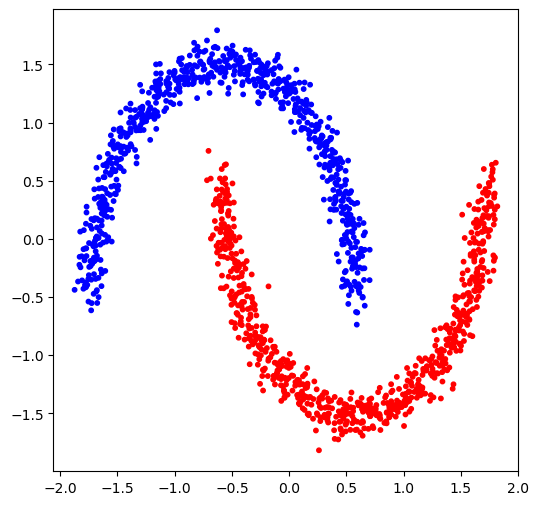

Silhouette score: 0.3891199513969138


In [15]:
# choice of dataset
index = 1
spectral_cluster = SpectralClustering(n_clusters=2,n_init=10,assign_labels='kmeans',gamma=10.) 
#-- note: can try other ways to assign labels, e.g. 'discretize' or 'cluster_qr'

# performing the clustering
X,Y = chosen_datasets[index]
spectral_cluster.fit(X)
Y_pred = spectral_cluster.labels_

# plot the figure
plt.figure(figsize=(6,6))
plt.scatter(X[:,0],X[:,1],s=10,color=colors[Y_pred])
plt.show()

# evaluation of the performance
print("Silhouette score:",silhouette_score(X,Y_pred))

**Question 6.** Test the influence of the various parameters for the datasets at hand.

For 'blobs', the behavior is the same as for other methods for $K=2,3$, but for $K=4$, more than one cluster is decomposed; for $K=6$, one of the cluster is decomposed into 3 subclusters. 

For the other data sets, the result is similar to K-means, even if other assignement strategies are considered. This can however be changed when constructing more carefully the graph Laplacian. For 'noisy_circles' for instance, one option is to use *affinity="nearest_neighbors"* in order to reduce the adjacency matrix to account only for the nearest neighbor; or to set the parameter *gamma* in the default affinity function *rbf* to a value larger to 1, for instance *gamma=10*.

## Extension: MNIST data

For the final project, one possible extension to consider is to test (some of) the above methods for MNIST data, and compare the performance of the clustering methods using the information available on the labels. The values of the parameters should be tested more thoroughly than here.

One could also consider generative methods based on GMM; see https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html, as well as https://datahype.net/2015/12/29/mixture-models-intro/ for a very simple code